In [16]:
# base
import pandas as pd 
import geopandas as gpd
import numpy as np
import zipfile
import os
import datetime
import random

# graph
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# ML
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler, RobustScaler
import pmdarima
import numba
from statsmodels.tsa.api import SARIMAX
from sktime.datatypes import check_raise, convert_to
from sklearn.linear_model import LinearRegression
from sktime.transformations.series.dummies import SeasonalDummiesOneHot

# function
import famDataset
# force reload to not restart jupyter each time
from importlib import reload
reload(famDataset)

<module 'famDataset' from '/home/tibo/Documents/Github/projet-fil-rouge-TiboGar-1/data/famDataset.py'>

In [3]:
# ----------------------------- #
# User input
# ----------------------------- #

# Especes
espece='Blé tendre'
espece='Maïs'

# ----------------------------- #
# Init
# ----------------------------- #
fam = famDataset.famDataset(root_dir=os.getcwd())
fam.load_transformed_data(convert_attributes = True, drop_attributes = False, pivot_to_long = False)
fam.load_geometry_data()

fam_data = fam.transformed_data.copy()

fam_data


Raw data loading complete
Raw data processed in transformed_data
Geom data loading complete


,ESPECES,DEP,DATE,CAMPAGNE,TOTAL_COLLECTE,STOCKS,STOCKS_DEPOTS,ENTREE_DEPOT,SORTIE_DEPOT,REPRISE_DEPOT,CORRECT_COLLECTE,ENTREE,LAG_DIFF,SORTIE
0,Avoine,01,2000-07-01,2000/01,2245.9,2642.7,151.0,162.2,0.0,1.4,0.0,2408.1,0.0,-2247.3
1,Avoine,01,2000-08-01,2000/01,461.6,2886.8,198.4,96.3,0.0,38.4,0.0,557.9,244.1,-255.9
2,Avoine,01,2000-09-01,2000/01,76.8,2495.0,193.2,18.6,0.0,25.5,0.0,95.4,-391.8,-494.1
3,Avoine,01,2000-10-01,2000/01,21.7,2196.9,191.1,0.0,-7.7,3.5,0.0,21.7,-298.1,-315.6
4,Avoine,01,2000-11-01,2000/01,28.4,1976.2,183.9,11.4,0.0,16.2,0.0,39.8,-220.7,-265.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466939,Triticale,2A,2025-06-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466940,Triticale,2A,2025-07-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466941,Triticale,2A,2025-08-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466942,Triticale,2A,2025-09-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='DATE'>

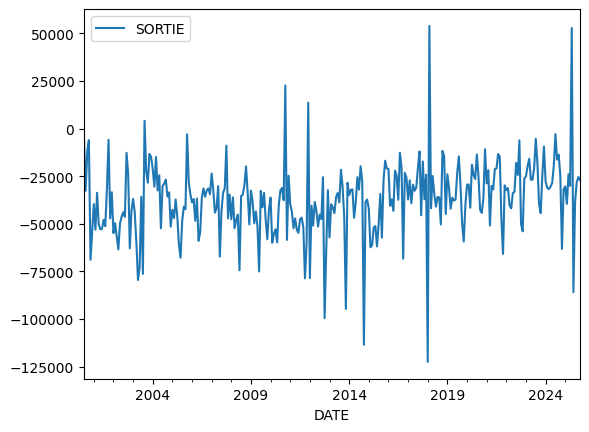

In [4]:
# ----------------------------- #
# target
# ----------------------------- #

df = famDataset.make_sktime_multiindex(fam_data, especes = espece, variable= 'SORTIE')
y = df.loc['01']
y.plot()

# SARIMAX function

In [ ]:
# create seasonal dummies, excluding first month
transformer = SeasonalDummiesOneHot(freq='M', drop= True)
X_seas = transformer.fit_transform(y=y, X=None)

# sarima model
model = SARIMAX(endog = y, 
                exog = X_seas,
                trend = 'c',
                order=(1,0,0),
                seasonal_order=(1,0,0,12))

result = model.fit(disp=False)
print(result.summary())



ValueError: Valid trend inputs are 'c' (constant), 't' (linear trend in time), 'ct' (both), 'ctt' (both with trend squared) or an interable defining a polynomial, e.g., [1, 1, 0, 1] is `a + b*t + ct**3`. Received 3

# Using scikit learn

In [5]:
# create seasonal dummies, excluding first month
transformer = SeasonalDummiesOneHot(freq='M', drop= True)
X_seas = transformer.fit_transform(y=y, X=None)

# create trend dummies, up to 3rd order
X_trend = pd.DataFrame({'poly1':range(len(y)),
                        'poly2':range(len(y)),
                        'poly3':range(len(y))})

X_trend['poly2'] = X_trend['poly2'] ** 2
X_trend['poly3'] = X_trend['poly3'] ** 3

X_trend.index = X_seas.index

X = pd.concat([X_seas, X_trend], axis = 1)

model = LinearRegression(fit_intercept=True)

model.fit(X = X, y=y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [6]:
df_coefs = pd.DataFrame({'feature_name':model.feature_names_in_,'coef':model.coef_[0]})
df_coefs.loc[-1] = ['intercept', model.intercept_[0]]

print(df_coefs.head(15))



    feature_name          coef
 0           Feb   5614.605495
 1           Mar  -2047.564416
 2           Apr  -1335.735929
 3           May   2103.960758
 4           Jun  -5389.984552
 5           Jul   6772.396707
 6           Aug  11468.208356
 7           Sep   9168.421677
 8           Oct   3658.554011
 9           Nov  -5116.360414
 10          Dec   9557.041298
 11        poly1   -135.273166
 12        poly2      0.873785
 13        poly3     -0.000967
-1     intercept -39568.865832


In [7]:
residuals = (model.predict(X) - y)
estim_seas = (X_seas * model.coef_[0][:X_seas.shape[1]]).sum(axis = 1)
estim_trend = (X_trend * model.coef_[0][X_seas.shape[1]:]).sum(axis = 1)

#y = np.asarray(y)
#residuals = np.asarray(residuals)

ssr = np.sum(residuals**2, axis = 0)
sst = np.sum((y - np.mean(y))**2, axis = 0)

r_squared = 1 - ssr / sst
r_squared


SORTIE    0.157973
dtype: float64

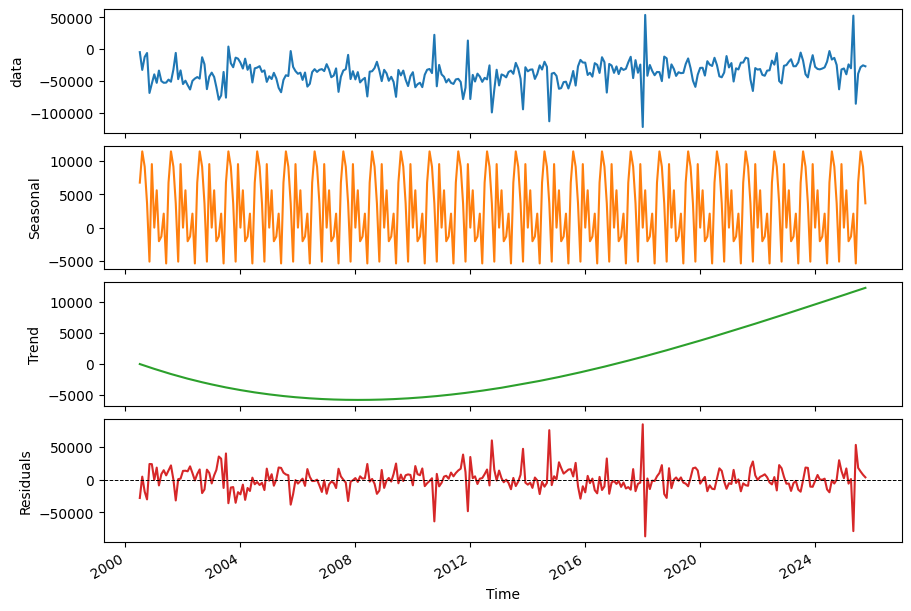

In [ ]:

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(9, 6), constrained_layout=True)

axes[0].plot(y.index, y, color='C0')
axes[0].set_ylabel('data')

axes[1].plot(y.index, estim_seas, color='C1')
axes[1].set_ylabel('Seasonal')

axes[2].plot(y.index, estim_trend, color='C2')
axes[2].set_ylabel('Trend')

axes[3].plot(y.index, residuals, color='C3')
axes[3].axhline(0, color='k', lw=0.7, ls='--')
axes[3].set_ylabel('Residuals')
# X-axis label only on bottom plot
axes[3].set_xlabel('Time')

# Optional: improve x ticks for datetime index
if isinstance(y.index, pd.DatetimeIndex):
    fig.autofmt_xdate()

plt.show()

# Using statmodels

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL


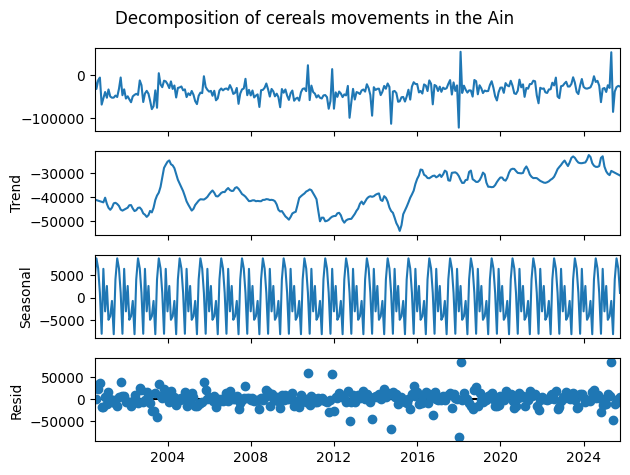

In [10]:
result = seasonal_decompose(y, period = 12, extrapolate_trend=12)

result.plot()

plt.suptitle('Decomposition of cereals movements in the Ain')
plt.tight_layout()
plt.show()


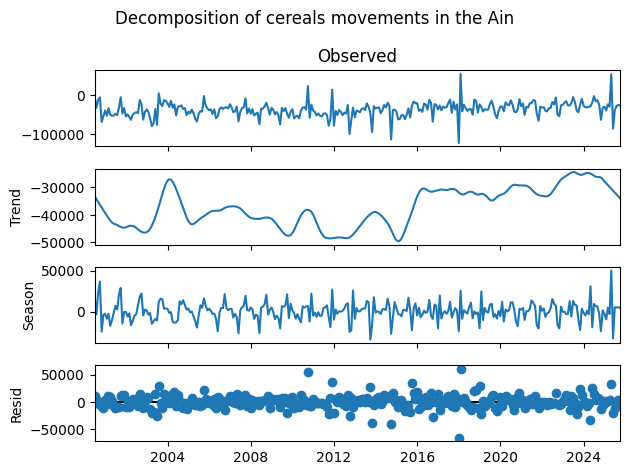

In [11]:
result = STL(y, period = 12, seasonal = 7).fit()

result.plot()

plt.suptitle('Decomposition of cereals movements in the Ain')
plt.tight_layout()
plt.show()


In [12]:
random.gauss(0,2)

-1.8597588336832993